## Examples of using of OpenAI's GPT through the API

### Section: PPO model learning

#### Writer
    Kunwoong Kim

#### Created / Last edited
    2023.06.23 / 2023.06.23

#### Notes
    Please be aware of the billing associated with using OpenAI's API!
    This notebook is written based on:

<https://medium.com/@yongsun.yoon/fine-tuning-openai-gpt-3-using-a-custom-reward-model-cae423753600>

I highly appreciate the author of this article.

In [23]:
import openai
import os
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from tqdm import tqdm
from matplotlib import pyplot as plt

def rewarder(sents, model, tokenizer, batch_size):
    rewards = []
    for batch_start in tqdm(range(0, len(sents), batch_size)):
        batch_sent = sents[batch_start : batch_start + batch_size]
        batch_inputs = tokenizer(batch_sent, padding=True, return_tensors='pt')
        batch_outputs = model(**batch_inputs)
        batch_rewards = torch.softmax(batch_outputs.logits, dim=-1)[:, 2]
        batch_rewards = (batch_rewards * 100.0).tolist()
        batch_rewards = [int(batch_reward) for batch_reward in batch_rewards]
        rewards += batch_rewards
    return rewards

In [24]:
"""""""""""""""""""""
OpenAI API: create your API key
"""""""""""""""""""""
# API key
openai.api_key = 'YOUR-API-KEY' # for sharing

In [ ]:
"""""""""""""""""""""
1. Pretrained model
"""""""""""""""""""""

""" Configuration """
# model engine
model = 'text-curie-001' # model curie is better than model davinci
# number of completions
n_completions = 100
# max tokens
max_tokens = 128
# obtain example responses
example_response = openai.Completion.create(
    model=model,
    prompt='Write a realistic movie review.',
    echo=False,
    max_tokens=max_tokens,
    n=n_completions
    )
completions = [choice.text.strip().replace('\n', ' ') for choice in example_response.choices]
completions = [completion for completion in completions if len(completion) > 1]
for i, completion in enumerate(completions):
    print(f'Generated sentence {i+1}: \n \t {completion}')

reward_model = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = AutoTokenizer.from_pretrained(reward_model)
reward_model = AutoModelForSequenceClassification.from_pretrained(reward_model)
_ = reward_model.requires_grad_(False).eval()
plm_rewards = rewarder(completions, reward_model, tokenizer, batch_size=8)

In [ ]:
"""""""""""""""""""""
2. After in-context learning
"""""""""""""""""""""

in_contexts = 'Write a realistic movie review.\n\n'
in_contexts += 'rating: 95\nreview: I really love this movie. This movie is so interesting. I would like to recommend.\n\n'
in_contexts += 'rating: 10\nreview: Lunch today was so bad. So salty pizza slices..\n\n'
in_contexts += 'rating: 80\nreview: This story was not too bad.\n\n'
in_contexts += 'rating: 49\nreview: Book is my life. I would like to recommend reading books everyday.\n\n'
in_contexts += 'rating: 79\nreview: IT WAS SO GREAT!\n\n'
in_contexts += 'rating: 92\nreview: This movie would make everyone laugh! You should try it!\n\n'
in_contexts += 'rating: 26\nreview: Hungry day.. Wanna go eat burger and fries?\n\n'
in_contexts += 'rating: 50\nreview: She is looking forward to enjoying her vacation...\n\n'
in_contexts += 'rating: 96\nreview: The story writer is so amazing I guess. He would make other interesting films more and more, I anticipate.\n\n'
in_contexts += 'rating: 46\nreview: Why is it so terrible? Ruined day...\n\n'
in_contexts += 'rating: 100\nreview:'

""" Configuration """
# model engine
model = 'text-davinci-001' # model curie is better than model davinci
# number of completions
n_completions = 100
# max tokens
max_tokens = 128
# obtain example responses
example_response = openai.Completion.create(
    model=model,
    prompt=in_contexts,
    echo=False,
    max_tokens=max_tokens,
    n=n_completions
    )
completions = [choice.text.strip().replace('\n', ' ') for choice in example_response.choices]
completions = [completion for completion in completions if len(completion) > 1]
for i, completion in enumerate(completions):
    print(f'Generated sentence {i+1}: \n \t {completion}')

in_context_rewards = rewarder(completions, reward_model, tokenizer, batch_size=8)

In [ ]:
"""""""""""""""""""""
3. After supervised fine-tuning
"""""""""""""""""""""

in_contexts = 'Write a realistic movie review.\n\n'
in_contexts += 'rating: 95\nreview: I really love this movie. This movie is so interesting. I would like to recommend.\n\n'
in_contexts += 'rating: 10\nreview: Lunch today was so bad. So salty pizza slices..\n\n'
in_contexts += 'rating: 80\nreview: This story was not too bad.\n\n'
in_contexts += 'rating: 49\nreview: Book is my life. I would like to recommend reading books everyday.\n\n'
in_contexts += 'rating: 79\nreview: IT WAS SO GREAT!\n\n'
in_contexts += 'rating: 92\nreview: This movie would make everyone laugh! You should try it!\n\n'
in_contexts += 'rating: 26\nreview: Hungry day.. Wanna go eat burger and fries?\n\n'
in_contexts += 'rating: 50\nreview: She is looking forward to enjoying her vacation...\n\n'
in_contexts += 'rating: 96\nreview: The story writer is so amazing I guess. He would make other interesting films more and more, I anticipate.\n\n'
in_contexts += 'rating: 46\nreview: Why is it so terrible? Ruined day...\n\n'

""" Configuration """
# model engine
model = 'curie'
# model hyperparams
n_epochs = 2
batch_size = 4
learning_rate_multiplier = 0.3
# Custom data
current_path = os.getcwd()
training_file = os.path.abspath(os.path.join(current_path, 'data/PPO_training_data.jsonl'))
assert os.path.exists(training_file)
# Upload to OpenAI
train_uploader = openai.File.create(file=open(training_file, 'rb'), purpose='fine-tune')

# config
configs = {
    'model': model,
    'n_epochs': n_epochs,
    'batch_size': batch_size,
    'learning_rate_multiplier': learning_rate_multiplier,
    'training_file': train_uploader.id
}


""" Fine-tuning process """
# creation
fine_tuner = openai.FineTune.create(**configs)
fine_tuning_end = False
fine_tuning_events = []
while True:
    late_event = openai.FineTune.retrieve(id=fine_tuner.id)['events'][-1]['message'] # OR: openai.FineTune.list_events(id=fine_tuner.id)
    late_status = openai.FineTune.retrieve(id=fine_tuner.id)['status']
    fine_tuning_end = (late_status == 'succeeded') or (late_status == 'failed')
    if late_event not in fine_tuning_events:
        fine_tuning_events.append(late_event)
        print(f'[Info] current event: {late_event}')
    if fine_tuning_end:
        break

In [ ]:
""" Inference"""
n_completions = 100
max_tokens = 128

fine_tuned_model = openai.FineTune.retrieve(id=fine_tuner.id).fine_tuned_model
example_prompt = 'Write a realistic movie review.\n\nrating: 100\nreview: '
example_response = openai.Completion.create(
    model=fine_tuned_model,
    prompt=example_prompt,
    max_tokens=max_tokens,
    temperature=0.5,
    n=n_completions
    )
completions = [choice.text.strip().replace('\n', ' ') for choice in example_response.choices]
completions = [completion for completion in completions if len(completion) > 1]
for i, completion in enumerate(completions):
    print(f'Generated sentence {i+1}: \n \t {completion}')
sft_rewards = rewarder(completions, reward_model, tokenizer, batch_size=8)

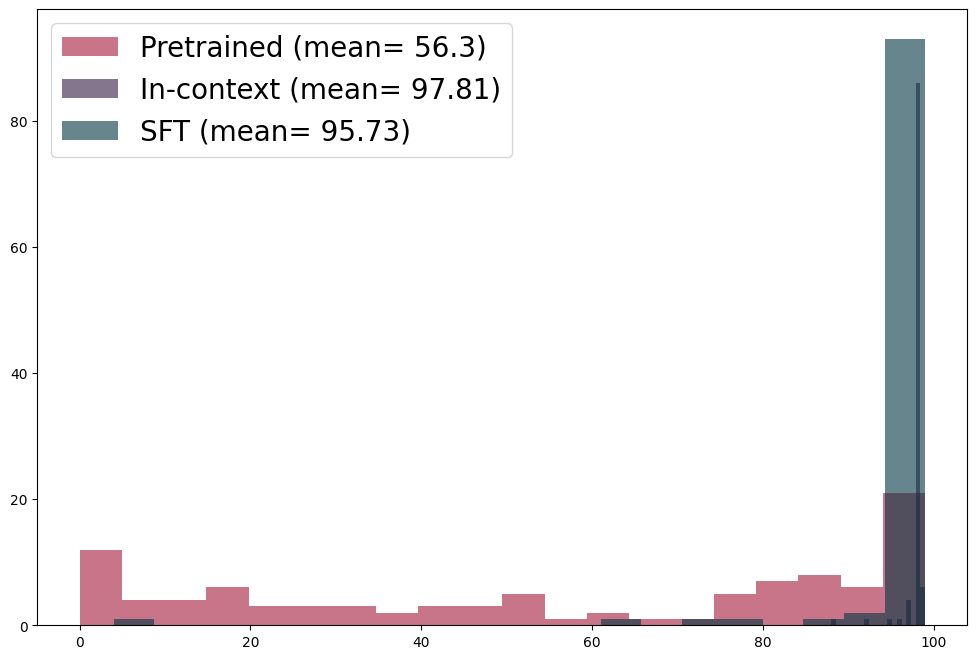

In [60]:
# plotting
plt.figure(figsize=(12, 8))
plt.hist(plm_rewards, density=False, bins=20, color='#A4193D', label=f'Pretrained (mean= {round(np.mean(plm_rewards), 2)})', alpha=0.6)
plt.hist(in_context_rewards, density=False, bins=20, color='#331B3F', label=f'In-context (mean= {round(np.mean(in_context_rewards), 2)})', alpha=0.6)
plt.hist(sft_rewards, density=False, bins=20, color='#02343F', label=f'SFT (mean= {round(np.mean(sft_rewards), 2)})', alpha=0.6)
plt.legend(fontsize=20.0)
plt.show()

In [ ]:
"""""""""""""""""""""
4. After in-context learning vs. supervised fine-tuning (rating: 0)
"""""""""""""""""""""

""" in-context """

in_contexts = 'Write a realistic movie review.\n\n'
in_contexts += 'rating: 95\nreview: I really love this movie. This movie is so interesting. I would like to recommend.\n\n'
in_contexts += 'rating: 10\nreview: Lunch today was so bad. So salty pizza slices..\n\n'
in_contexts += 'rating: 80\nreview: This story was not too bad.\n\n'
in_contexts += 'rating: 49\nreview: Book is my life. I would like to recommend reading books everyday.\n\n'
in_contexts += 'rating: 79\nreview: IT WAS SO GREAT!\n\n'
in_contexts += 'rating: 92\nreview: This movie would make everyone laugh! You should try it!\n\n'
in_contexts += 'rating: 26\nreview: Hungry day.. Wanna go eat burger and fries?\n\n'
in_contexts += 'rating: 50\nreview: She is looking forward to enjoying her vacation...\n\n'
in_contexts += 'rating: 96\nreview: The story writer is so amazing I guess. He would make other interesting films more and more, I anticipate.\n\n'
in_contexts += 'rating: 46\nreview: Why is it so terrible? Ruined day...\n\n'
in_contexts += 'rating: 0\nreview:'

# model engine
model = 'text-davinci-001' # model curie is better than model davinci
# number of completions
n_completions = 100
# max tokens
max_tokens = 128
# obtain example responses
example_response = openai.Completion.create(
    model=model,
    prompt=in_contexts,
    echo=False,
    max_tokens=max_tokens,
    n=n_completions
    )
completions = [choice.text.strip().replace('\n', ' ') for choice in example_response.choices]
completions = [completion for completion in completions if len(completion) > 1]
for i, completion in enumerate(completions):
    print(f'Generated sentence {i+1}: \n \t {completion}')

in_context_rewards_0 = rewarder(completions, reward_model, tokenizer, batch_size=8)


""" Inference"""
n_completions = 100
max_tokens = 128

fine_tuned_model = openai.FineTune.retrieve(id=fine_tuner.id).fine_tuned_model
example_prompt = 'Write a realistic movie review.\n\nrating: 0\nreview: '
example_response = openai.Completion.create(
    model=fine_tuned_model,
    prompt=example_prompt,
    max_tokens=max_tokens,
    temperature=0.5,
    n=n_completions
    )
completions = [choice.text.strip().replace('\n', ' ') for choice in example_response.choices]
completions = [completion for completion in completions if len(completion) > 1]
for i, completion in enumerate(completions):
    print(f'Generated sentence {i+1}: \n \t {completion}')
sft_rewards_0 = rewarder(completions, reward_model, tokenizer, batch_size=8)


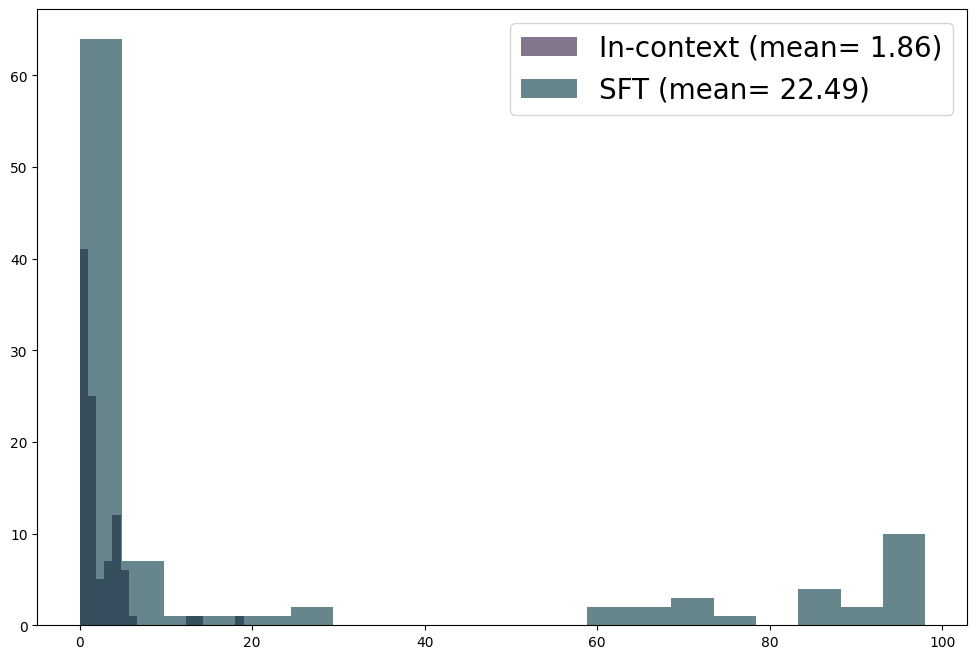

In [62]:
# plotting
plt.figure(figsize=(12, 8))
plt.hist(in_context_rewards_0, density=False, bins=20, color='#331B3F', label=f'In-context (mean= {round(np.mean(in_context_rewards_0), 2)})', alpha=0.6)
plt.hist(sft_rewards_0, density=False, bins=20, color='#02343F', label=f'SFT (mean= {round(np.mean(sft_rewards_0), 2)})', alpha=0.6)
plt.legend(fontsize=20.0)
plt.show()